In [2]:
# This notebook is to test the passive strap idea, which are after the feeds on either side. 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from TWA_Design_Tools import TWA_Design_Toolkit
from TWA_skrf_Toolkit import TWA_skrf_Toolkit as rftoolkit
import skrf as rf
from scipy.optimize import minimize

In [4]:
# this notebook is to test that everything in center fed mode works as expected
num_straps = 13
f0 = 96e6
w0 = 2*np.pi*f0
clight = 3e8
Rant = 1.12 # m, hfs of d3d

# See code logbook "my antenna" section. This is for shot 147634. 
n_par = -5 
k_par = w0*n_par/clight
print(f'k_par : {k_par} 1/m')
n_phi = Rant*k_par
print(f'n_phi: {n_phi}')

# settings to create the rf toolkit object 
capz0 = 9.3506
antz0 = 30
freqs_for_fullant = np.arange(81,112, 1)
# capfile = 'circ_model/S11_cap_81to111MHz_16_cmcapbox.csv'
capfile = 'circ_model/S11_cap_81to111MHz_20cmcapbox.csv'
antfile = 'circ_model/fixed_bigscan_full_CF_13strap_2passive.csv' 
myrfTWA = rftoolkit(num_straps=num_straps, f0=f0, k_par_max=k_par, capz0=capz0, 
                    antz0=antz0, freqs_for_fullant=freqs_for_fullant, capfile=capfile, antfile=antfile, center_fed_mode=True)

# add items to geometry
ar = 1.5e-2
d = 15.625e-2
s0 = 16e-2
wstrap = 8e-2
l = 15e-2
ts = 0.5e-2
tbox = 1e-2
h = .5e-2
t_cap_extend = 0.25e-2
wcap = wstrap + 2*t_cap_extend # 1 cm on either side
wcapbox = wcap + 2*h
tdiv = myrfTWA.geometry_dict['s_rez'] - 2*h - wcap 
dcap = ts + 2*t_cap_extend
dcapbox = dcap + 2*h
lcapbox = 10e-2
lcut = 6e-2
ldeembed = 5e-2
lfeed = 10e-2

myrfTWA.add_to_geometry('ar', ar)
myrfTWA.add_to_geometry('d', d)
myrfTWA.add_to_geometry('s0', s0)
myrfTWA.add_to_geometry('wstrap', wstrap)
myrfTWA.add_to_geometry('l', l)
myrfTWA.add_to_geometry('ts', ts)
myrfTWA.add_to_geometry('tbox', tbox)
myrfTWA.add_to_geometry('h', h)
myrfTWA.add_to_geometry('t_cap_extended', t_cap_extend)
myrfTWA.add_to_geometry('wcap', wcap)
myrfTWA.add_to_geometry('wcapbox', wcapbox)
myrfTWA.add_to_geometry('tdiv', tdiv)
myrfTWA.add_to_geometry('dcap', dcap)
myrfTWA.add_to_geometry('dcapbox', dcapbox)
myrfTWA.add_to_geometry('lcapbox', lcapbox)
myrfTWA.add_to_geometry('lcut', lcut)
myrfTWA.add_to_geometry('ldeembed', ldeembed)
myrfTWA.add_to_geometry('lfeed', lfeed)

myrfTWA.print_geometry()

k_par : -10.053096491487338 1/m
n_phi: -11.25946807046582
num_straps:     13
s_rez:          0.15625
lamda0:         3.1228381041666666
ar:             0.015
d:              0.15625
s0:             0.16
wstrap:         0.08
l:              0.15
ts:             0.005
tbox:           0.01
h:              0.005
t_cap_extended: 0.0025
wcap:           0.085
wcapbox:        0.095
tdiv:           0.061249999999999985
dcap:           0.01
dcapbox:        0.02
lcapbox:        0.1
lcut:           0.06
ldeembed:       0.05
lfeed:          0.1


In [3]:
# try out the knew optimization function. Start with very low alpha and beta, and lamda largeish. 
#bounds = [(0.05, 0.154)]*7#[(0.02, 0.095)]*5
bounds = [(0.05, 0.194)]*7#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
alpha = 17500 # 10,000 worked well 
gamma = 5000
lam1 = 0 # phase op
lam2 = 0 # power ratio op 
target_npar = 5.6#5.6 # TODO: change back to 5
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 10]
num_npars = 100
workers = 4

res = myrfTWA.run_differential_evolution_global_op_npar_match_low_npar_zero_cancel_image_currents( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            alpha_npar_op=alpha,
                                            gamma_npar_op=gamma,
                                            target_npar=target_npar,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=workers)

c:\Users\jacob\anaconda3\envs\waves\Lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


KeyboardInterrupt: 

In [91]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist()
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.12653776988252402, 0.16103984473714858, 0.11548597373880301, 0.12662459981768107, 0.09676721603572055, 0.10228532656041134, 0.15329885506872595]
The phase difference is 174.7633056146781 deg
The power ratio I_2^2 / I_1^2 = 2.235250308083817


final lengths: [0.12653776988252402, 0.16103984473714858, 0.11548597373880301, 0.12662459981768107, 0.09676721603572055, 0.10228532656041134, 0.15329885506872595]


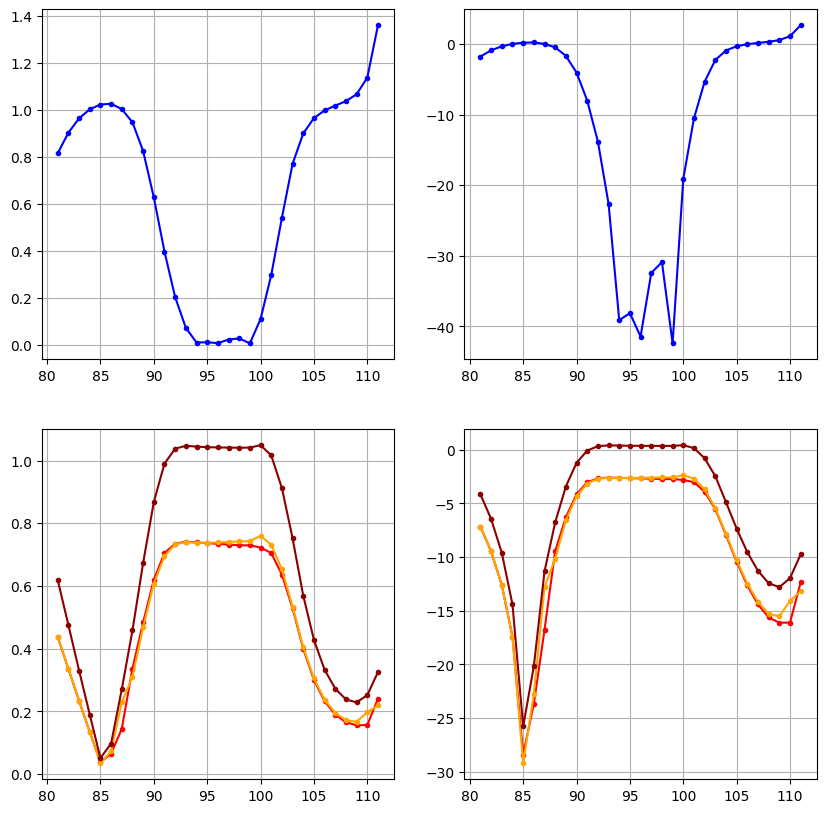

In [92]:
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

port indicies [1, 3, 5]
[ 0.49101499-0.01472245j -0.49101499+0.01472245j  0.0405238 +0.07690321j
 -0.0405238 -0.07690321j  0.03953557+0.07665274j -0.03953557-0.07665274j
 -0.31166087-0.14379992j  0.31166087+0.14379992j -0.13018626-0.04124528j
  0.13018626+0.04124528j  0.26929644-0.01621335j -0.26929644+0.01621335j
  0.3593687 +0.02217011j -0.3593687 -0.02217011j -0.06401659+0.02191786j
  0.06401659-0.02191786j -0.35775988+0.01541433j  0.35775988-0.01541433j
 -0.50499765-0.01097052j  0.50499765+0.01097052j -0.36195286+0.0188611j
  0.36195286-0.0188611j  -0.0650876 +0.02361775j  0.0650876 -0.02361775j
  0.35936524+0.02118924j -0.35936524-0.02118924j  0.27014189-0.0191578j
 -0.27014189+0.0191578j  -0.12878739-0.04206388j  0.12878739+0.04206388j
 -0.31333202-0.13930497j  0.31333202+0.13930497j]
--
[ 0.01099838+0.24746976j -0.05014353-0.36694087j  0.43195481-0.01678319j
 -0.1953045 +0.29091454j -0.22568386-0.16434145j  0.06821973-0.25560733j
  0.37406189+0.29117186j  0.07390318-0.25460492j 

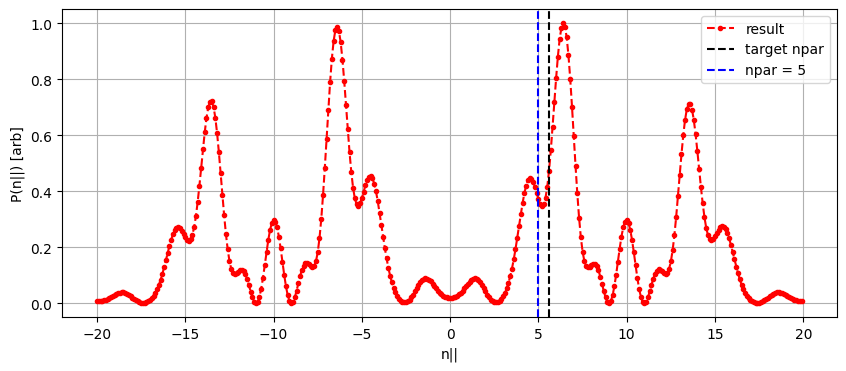

In [93]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(0, 10, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')
plt.legend()

In [26]:
# area to test out the new ideal profile code 
bounds = [(0.05, 0.194)]*7#[(0.02, 0.095)]*5
freq_bounds = (92,100)#(92, 100)
s11cutoff = -45

# new settings 
omega = 5000000
lam1 = 0 # phase op
lam2 = 0 # power ratio op 
target_npar = 5#5.6 # TODO: change back to 5
sigma = .8
target_PR = 2 # TODO: I do not know what the desired power ratio is. 
npar_bounds = [0, 10]
num_npars = 100
workers = 4

Text(0, 0.5, 'Power [a.u.]')

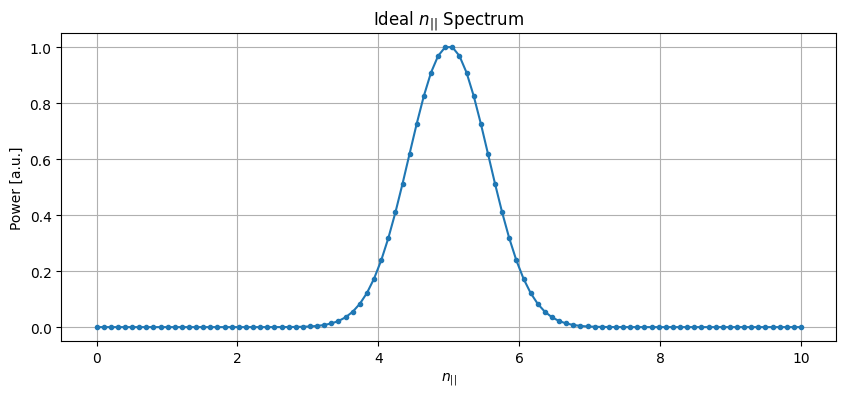

In [27]:
# plot of the ideal npar spectrum 
npar_array_for_ideal = np.linspace(npar_bounds[0], npar_bounds[1], num_npars)
ideal_spec = myrfTWA.normalized_npar_ideal(npar_array_for_ideal, ntarget=target_npar, sigma=sigma)
plt.figure(figsize=(10,4))
plt.plot(npar_array_for_ideal, ideal_spec, marker='.')
plt.grid()
plt.title(r'Ideal $n_{||}$ Spectrum')
plt.xlabel(r'$n_{||}$')
plt.ylabel('Power [a.u.]')

In [28]:

res = myrfTWA.run_differential_evolution_global_op_total_npar_spectrum_match_cancel_image_currents( 
                                            length_bounds=bounds,
                                            S11_db_cutouff=s11cutoff,
                                            freq=96e6, # in Hz
                                            freq_bounds=freq_bounds,
                                            omega_npar_op=omega,
                                            sigma_for_ideal_npar=sigma,
                                            target_npar=target_npar,
                                            npar_bounds=npar_bounds, # for finding the maximum for the optimization 
                                            num_npars=num_npars,
                                            lam1_image_current_phase_op=lam1,
                                            lam2_image_current_mag_op=lam2,
                                            target_power_ratio_image_current_op=target_PR,
                                            strategy='best1bin',
                                            symetric_mode=True,
                                            one_cap_type_mode=False,
                                            end_cap_mode=False,
                                            workers=workers)


----------------------------------------
i_iter = 1
New simulation.
Point is: [0.10691696 0.07651164 0.10303742 0.06097497 0.1070634  0.1939932
 0.09449019]
Average absolute error is : 1.21e+05
----------------------------------------
i_iter = 2
New simulation.
Point is: [0.10691697 0.07651164 0.10303742 0.06097497 0.1070634  0.1939932
 0.09449019]
Average absolute error is : 1.21e+05
----------------------------------------
i_iter = 3
New simulation.
Point is: [0.10691696 0.07651165 0.10303742 0.06097497 0.1070634  0.1939932
 0.09449019]
Average absolute error is : 1.21e+05
----------------------------------------
i_iter = 4
New simulation.
Point is: [0.10691696 0.07651164 0.10303743 0.06097497 0.1070634  0.1939932
 0.09449019]
Average absolute error is : 1.21e+05
----------------------------------------
i_iter = 5
New simulation.
Point is: [0.10691696 0.07651164 0.10303742 0.06097498 0.1070634  0.1939932
 0.09449019]
Average absolute error is : 1.21e+05
------------------------------

In [34]:
# check the phase diff and power ratio between the first and second straps (including any passive straps)
lengths_found = res.x.tolist()
#lengths_found = [0.13254054, 0.09346692, 0.0602741, 0.07834545, 0.06088853, 0.11657295]
print('final lengths:', lengths_found)
phase_diff, PR = myrfTWA.get_phase_diff_and_PR_straps_1_and_2(lengths=lengths_found.copy(), 
                                                        freq=myrfTWA.freq_for_npar_op,
                                                        power=[1,0,0],
                                                        phase=[0,0,0],
                                                        symetric_mode=True,
                                                        one_cap_type_mode=False,
                                                        end_cap_mode=False)

print(f'The phase difference is {phase_diff*180/np.pi} deg')
print(f'The power ratio I_2^2 / I_1^2 = {PR}')

final lengths: [0.10713031085480045, 0.07653635344299041, 0.10334199789158666, 0.06104064775976781, 0.10681852406461352, 0.194, 0.09445569044738547]
The phase difference is 176.05898269108715 deg
The power ratio I_2^2 / I_1^2 = 0.04988072713237092


final lengths: [0.10713031085480045, 0.07653635344299041, 0.10334199789158666, 0.06104064775976781, 0.10681852406461352, 0.194, 0.09445569044738547]


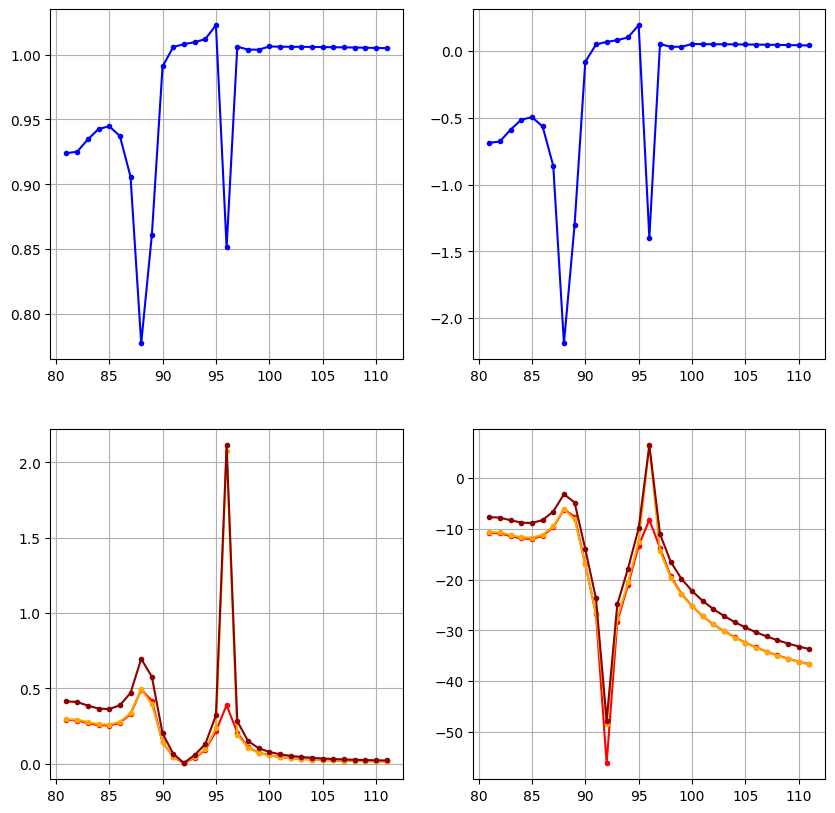

In [35]:
#lengths_found = [0.194, 0.1313866735714255, 0.08289423924416277, 0.06213359442830035, 0.09767239308875371, 0.1175386770606046, 0.14438872750235227]
print('final lengths:',lengths_found)
full_net_optimized = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True) #TODO: make true

S11_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S21_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')
S31_array = np.zeros_like(myrfTWA.freqs_for_fullant, dtype='complex')

for i in range(S11_array.shape[0]):
    S11, S21, S31 = myrfTWA.get_full_TWA_network_S11_S21(fullnet=full_net_optimized, f=myrfTWA.freqs_for_fullant[i])
    S11_array[i] = S11
    S21_array[i] = S21
    S31_array[i] = S31

S11_mag_array = np.zeros_like(S11_array)
S11_db_array = np.zeros_like(S11_array)

S21_mag_array = np.zeros_like(S11_array)
S21_db_array = np.zeros_like(S11_array)

S31_mag_array = np.zeros_like(S11_array)
S31_db_array = np.zeros_like(S11_array)


for i in range(S11_array.shape[0]):
    S11_mag_array[i] = np.abs(S11_array[i])
    S11_db_array[i] = 20*np.log10(S11_mag_array[i])
    S21_mag_array[i] = np.abs(S21_array[i])
    S21_db_array[i] = 20*np.log10(S21_mag_array[i])
    S31_mag_array[i] = np.abs(S31_array[i])
    S31_db_array[i] = 20*np.log10(S31_mag_array[i])

fig, ax = plt.subplots(2,2,figsize=(10,10))

Strans_mag = np.sqrt(S31_mag_array**2 + S21_mag_array**2)
Strans_db = 20*np.log10(Strans_mag)

ax[0,0].plot(myrfTWA.freqs_for_fullant, S11_mag_array, marker='.', color='blue')
ax[0,1].plot(myrfTWA.freqs_for_fullant, S11_db_array, marker='.', color='blue')
ax[0,0].grid()
ax[0,1].grid()
ax[1,0].plot(myrfTWA.freqs_for_fullant, S21_mag_array, marker='.', color='red')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S21_db_array, marker='.', color='red')
ax[1,0].plot(myrfTWA.freqs_for_fullant, S31_mag_array, marker='.', color='orange')
ax[1,1].plot(myrfTWA.freqs_for_fullant, S31_db_array, marker='.', color='orange')
ax[1,0].plot(myrfTWA.freqs_for_fullant, Strans_mag, marker='.', color='darkred')
ax[1,1].plot(myrfTWA.freqs_for_fullant, Strans_db, marker='.', color='darkred')
ax[1,0].grid()
ax[1,1].grid()

port indicies [1, 3, 5]
[ 0.06799976-0.14450609j -0.06799976+0.14450609j -0.07253038-0.01321108j
  0.07253038+0.01321108j -0.07386176-0.01389025j  0.07386176+0.01389025j
  0.09445706-0.05141274j -0.09445706+0.05141274j  0.04298319-0.02933379j
 -0.04298319+0.02933379j  0.12442942+0.02228053j -0.12442942-0.02228053j
  0.03863485+0.03391829j -0.03863485-0.03391829j  0.02273106+0.11430815j
 -0.02273106-0.11430815j -0.10641162+0.12111369j  0.10641162-0.12111369j
  0.04709795-0.18786672j -0.04709795+0.18786672j -0.10983975+0.11850613j
  0.10983975-0.11850613j  0.0260317 +0.11646572j -0.0260317 -0.11646572j
  0.03989172+0.03481948j -0.03989172-0.03481948j  0.12708898+0.02342765j
 -0.12708898-0.02342765j  0.04399188-0.029648j   -0.04399188+0.029648j
  0.09637286-0.05275246j -0.09637286+0.05275246j]
--
[-0.35194096-1.15637719e-01j  0.08019165+2.03631409e-02j
  0.53797632+3.47057892e-01j -0.05024973-1.59067287e-02j
 -0.70656204-4.13676420e-01j  0.33731339+2.29642679e-01j
  0.0536301 +2.93028175e

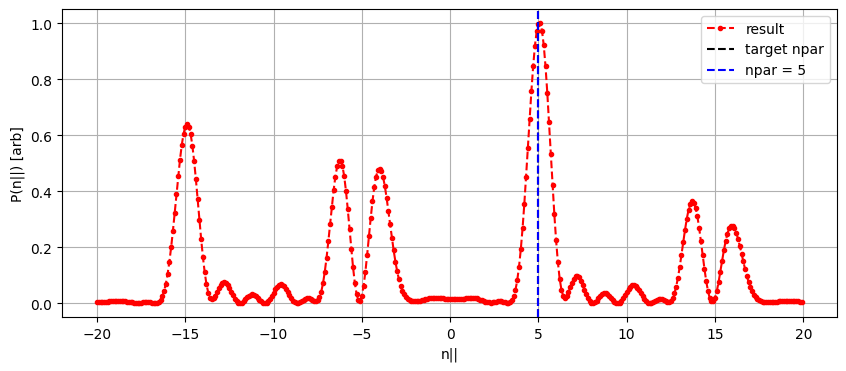

In [39]:
full_circ = myrfTWA.get_fullant_given_lengths_from_internal_datatable(lengths_found.copy(), symetric_mode=True,
                                                          one_cap_type_mode=False,
                                                          end_cap_mode=False,
                                                          return_circ=True)

power = [1, 0,0] # power excitation at the two ports 
phase = [0, 0,0 ] # radians 
print('port indicies', full_circ.port_indexes)
print(full_circ.currents(power,phase)[1,:])
print('--')
freq = 96e6
idx = np.where(full_circ.frequency.f_scaled == freq/1e6)
strap_current_array = full_circ.currents(power,phase)[idx,:].reshape(myrfTWA.num_straps + 3,2)[:,1][3:]  # remove double counting, remove two external ports 
print(strap_current_array)
# for now, use second row. 

def get_phase(complexn):
    real = np.real(complexn)
    imag = np.imag(complexn)
    angle_rad = np.arctan2(imag, real)
    return angle_rad
strap_phases = get_phase(strap_current_array)
print(strap_phases*180/np.pi)

npar_array = np.arange(-10, 0, .1)
npar_array = np.arange(-20, 20, .1)
print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')
plt.legend()

[-0.89894977  0.07915569  0.18237093 -0.90241463 -0.83139985  0.19026112
  0.01737478 -0.30061589  0.70534647  0.63711065 -0.27971137 -0.38319013
  0.63709391]


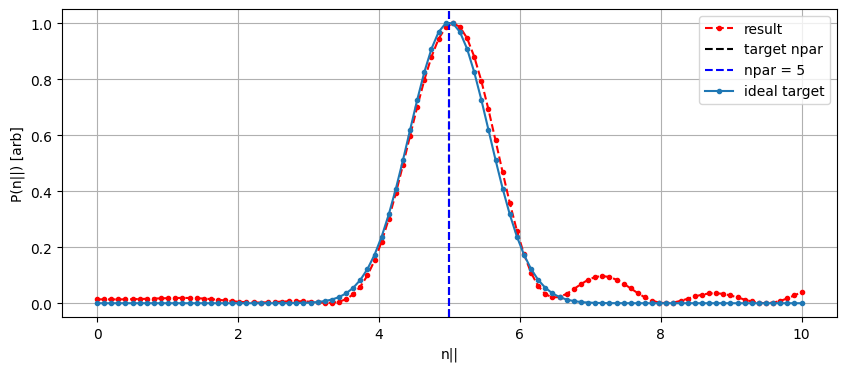

In [37]:

print(strap_phases/(np.pi))

result_circ_model = np.array([], dtype='complex')
for i in range(npar_array_for_ideal.shape[0]):
    power = myrfTWA.analytic_power_spectrum_general_phase_diff(npar_array_for_ideal[i], w_strap=myrfTWA.geometry_dict['wstrap'],
                                                                d_strap=myrfTWA.geometry_dict['d'],
                                                                freq=freq,
                                                                phase_array=strap_phases)
    result_circ_model = np.append(result_circ_model, power)

plt.figure(figsize=(10,4))
plt.grid()
plt.plot(npar_array_for_ideal, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='red', linestyle='--', label='result', marker='.')
#plt.plot(npar_array, np.real(result_circ_model)/np.max(np.real(result_circ_model)), color='purple', linestyle='--', label='shifted')
plt.xlabel('n||')
plt.ylabel('P(n||) [arb]')

plt.axvline(x=target_npar, ymin=0, ymax=1, color='k', linestyle='--', label='target npar')
plt.axvline(x=5, ymin=0, ymax=1, color='blue', linestyle='--', label='npar = 5')

plt.plot(npar_array_for_ideal, ideal_spec, marker='.', label='ideal target')

plt.legend()

[0.10713031085480045, 0.07653635344299041, 0.10334199789158666, 0.06104064775976781, 0.10681852406461352, 0.194, 0.09445569044738547]
True


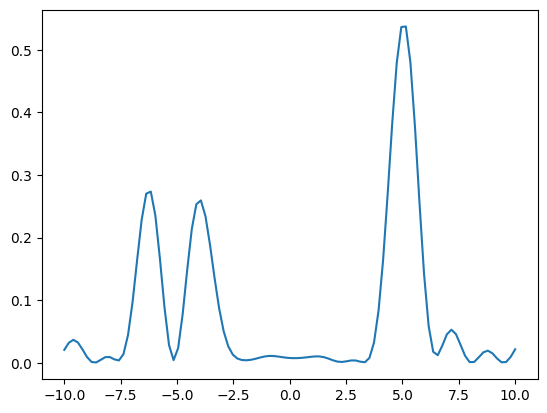

In [45]:
print(lengths_found)
print(myrfTWA.symetric_mode)
npar_bounds = [-10, 10]
npar_array = np.linspace(npar_bounds[0], npar_bounds[1], num_npars)
npar_spec_found = myrfTWA.get_npar_spectrum(lengths=lengths_found.copy(),
                                            npar_bounds=npar_bounds, #myrfTWA.npar_bounds_for_npar_op,
                                            freq=myrfTWA.freq_for_npar_op,
                                            num_npars=myrfTWA.num_npars_for_npar_op,
                                            power=[1,0,0],
                                            phase=[0,0,0],
                                            symetric_mode=myrfTWA.symetric_mode,
                                            one_cap_type_mode=myrfTWA.one_cap_type_mode,
                                            end_cap_mode=myrfTWA.end_cap_mode)

plt.plot(npar_array, npar_spec_found)